<a href="https://colab.research.google.com/github/angkitrg/ProgramSkripsi/blob/main/Classification_Cancer_Breast_With_RestNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow  as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Install Data From Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"candrajuliussinaga","key":"dca3be30de1a1edfcd83a0e68adab444"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d anissaapril/kanker-payudara/

 95% 440M/462M [00:04<00:00, 66.5MB/s]
100% 462M/462M [00:04<00:00, 103MB/s] 


In [ ]:
file_name  = '/content/kanker-payudara.zip'

In [ ]:
from zipfile import ZipFile
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Selesai mengekstrak zip')

Selesai mengekstrak zip


In [ ]:
base_dir = '/content/Citramammografi/Citramammografi/train'

In [ ]:
import os
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
  counting = len(os.listdir(os.path.join(base_dir,i)))
  number_label[i] = counting
  total_files += counting
  print('Total Files: ',str(total_files))
print('Jumlah semua file yang ada pada dataset : ',str(total_files))

Total Files:  137
Total Files:  398
Total Files:  531
Jumlah semua file yang ada pada dataset :  531


In [ ]:
import os
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
  counting = len(os.listdir(os.path.join(base_dir,i)))
  number_label[i] = counting
  total_files += counting
  print('Total Files: ',str(total_files))
print('Jumlah semua file yang ada pada dataset : ',str(total_files))

Total Files:  137
Total Files:  398
Total Files:  531
Jumlah semua file yang ada pada dataset :  531


Text(0, 0.5, 'Jumlah Gambar')

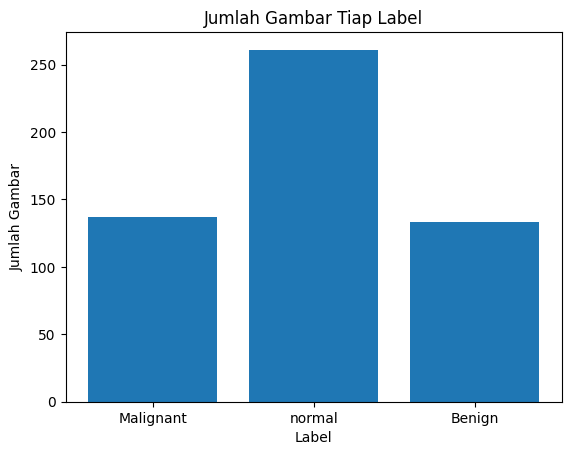

In [ ]:
import matplotlib.pyplot as plt
plt.bar(number_label.keys(), number_label.values())
plt.title("Jumlah Gambar Tiap Label")
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')

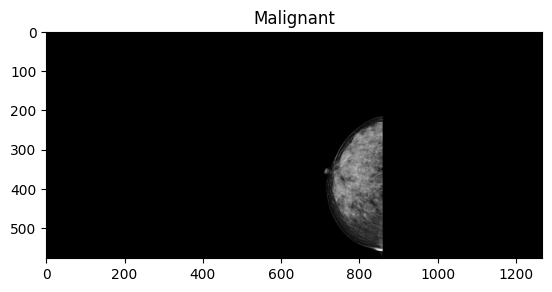

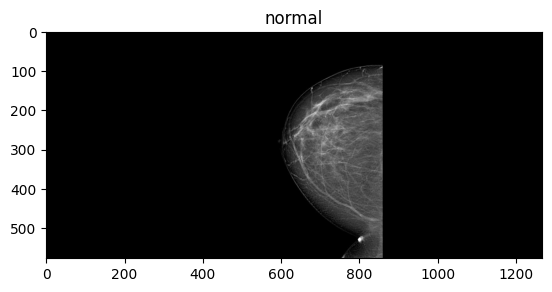

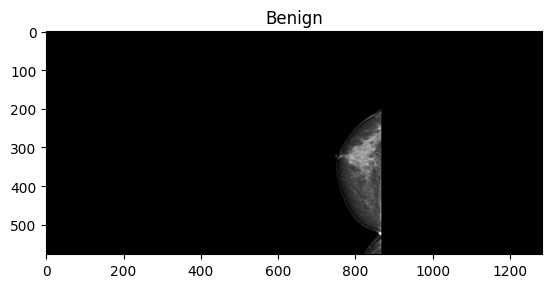

In [ ]:
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

In [ ]:
normal_dir = '/content/Citramammografi/Citramammografi/train/normal'
benign_dir = '/content/Citramammografi/Citramammografi/train/Benign'
malignant_dir = '/content/Citramammografi/Citramammografi/train/Malignant'

In [ ]:
img_normal_dir = os.listdir(normal_dir)
img_benign_dir = os.listdir(benign_dir)
img_malignant_dir = os.listdir(malignant_dir)

In [ ]:
import pandas as pd

In [ ]:
data = pd.DataFrame({
    'image_path' : [os.path.join(normal_dir, filename) for filename  in img_normal_dir] + [os.path.join(benign_dir,filename) for filename in img_benign_dir] + [os.path.join(malignant_dir, filename) for filename in img_malignant_dir],
    'class' : ["NORMAL"]* len(img_normal_dir) + ["BENIGN"]* len(img_benign_dir) + ["MALIGNANT"]* len(img_malignant_dir)
})

In [ ]:
file_csv = 'data.csv'
data.to_csv(file_csv, index=False)

In [ ]:
df = pd.read_csv('/content/data.csv')
df

,image_path,class
0,/content/Citramammografi/Citramammografi/train...,NORMAL
1,/content/Citramammografi/Citramammografi/train...,NORMAL
2,/content/Citramammografi/Citramammografi/train...,NORMAL
3,/content/Citramammografi/Citramammografi/train...,NORMAL
4,/content/Citramammografi/Citramammografi/train...,NORMAL
...,...,...
526,/content/Citramammografi/Citramammografi/train...,MALIGNANT
527,/content/Citramammografi/Citramammografi/train...,MALIGNANT
528,/content/Citramammografi/Citramammografi/train...,MALIGNANT
529,/content/Citramammografi/Citramammografi/train...,MALIGNANT


In [ ]:
df.shape

(531, 2)

In [ ]:
df.duplicated().sum()

0

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image
X = []
for img_path in df['image_path']:
    img = image.load_img(img_path, target_size=(227,227))
    img_array = image.img_to_array(img)
    X.append(img_array)
X = np.array(X)

# Normalize pixel values
X = X / 255.0

# Encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [ ]:
# Pisahkan data menjadi data pelatihan dan pengujian
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense

# Load pre-trained ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(227, 227, 3)))

# Freeze the layers of the ResNet50 base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = tf.keras.models.Sequential([
    base_model,
    Flatten(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 131072)            0         
                                                                 
 dropout_19 (Dropout)        (None, 131072)            0         
                                                                 
 dense_50 (Dense)            (None, 512)               67109376  
                                                                 
 dense_51 (Dense)            (None, 256)               131328    
                                                                 
 dense_52 (Dense)            (None, 128)               32896     
                                                                 
 dense_53 (Dense)            (None, 64)              

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_data=(X_test, y_test))

Epoch 1/150
12/12 [==============================] - 8s 343ms/step - loss: 2.2989 - accuracy: 0.4070 - val_loss: 1.0316 - val_accuracy: 0.4875
Epoch 2/150
12/12 [==============================] - 2s 164ms/step - loss: 1.0783 - accuracy: 0.5067 - val_loss: 1.0042 - val_accuracy: 0.5750
Epoch 3/150
12/12 [==============================] - 2s 165ms/step - loss: 1.0693 - accuracy: 0.5040 - val_loss: 1.2965 - val_accuracy: 0.4875
Epoch 4/150
12/12 [==============================] - 2s 164ms/step - loss: 1.0471 - accuracy: 0.5499 - val_loss: 0.8742 - val_accuracy: 0.6250
Epoch 5/150
12/12 [==============================] - 2s 177ms/step - loss: 0.9391 - accuracy: 0.5714 - val_loss: 1.1112 - val_accuracy: 0.4187
Epoch 6/150
12/12 [==============================] - 2s 166ms/step - loss: 1.0637 - accuracy: 0.4717 - val_loss: 0.9491 - val_accuracy: 0.5500
Epoch 7/150
12/12 [==============================] - 2s 175ms/step - loss: 0.9894 - accuracy: 0.5445 - val_loss: 0.9698 - val_accuracy: 0.4875

In [ ]:
accuracy_train = model.evaluate(X_train,y_train)[1]
print(f"Accuracy: {accuracy_train * 100:.2f}%")

12/12 [==============================] - 3s 105ms/step - loss: 0.8197 - accuracy: 0.6469
Accuracy: 64.69%


In [ ]:
accuracy_test = model.evaluate(X_test,y_test)[1]
print(f"Accuracy: {accuracy_test * 100:.2f}%")

5/5 [==============================] - 1s 106ms/step - loss: 0.8603 - accuracy: 0.6187
Accuracy: 61.87%


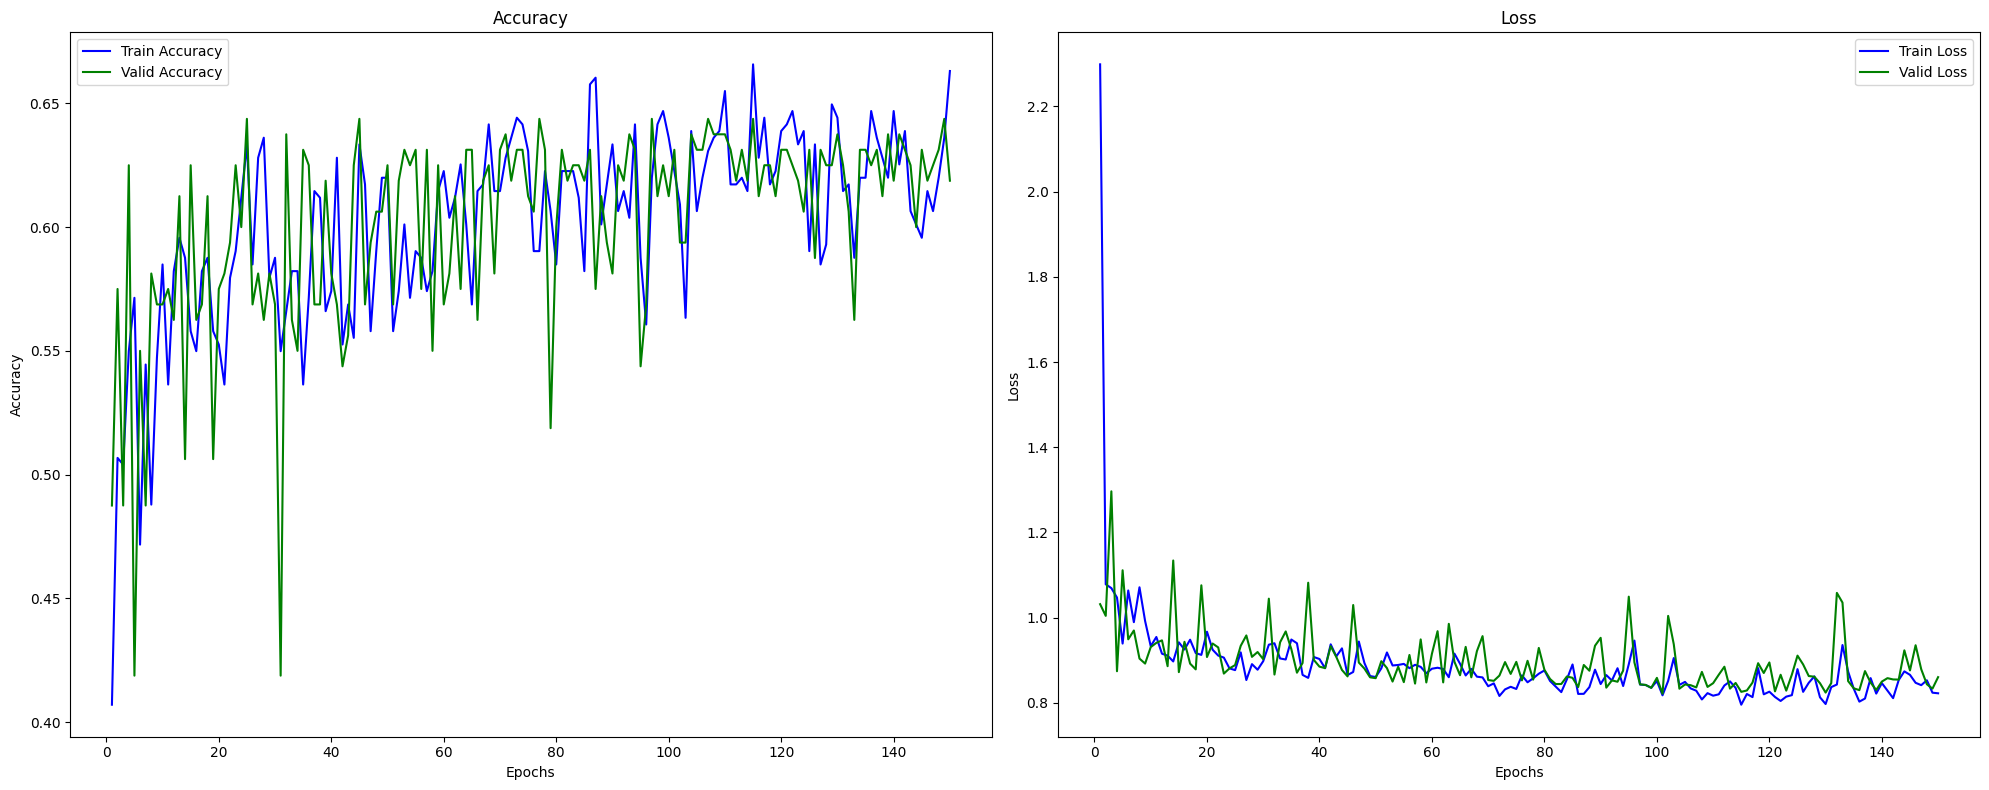

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

5/5 [==============================] - 1s 109ms/step


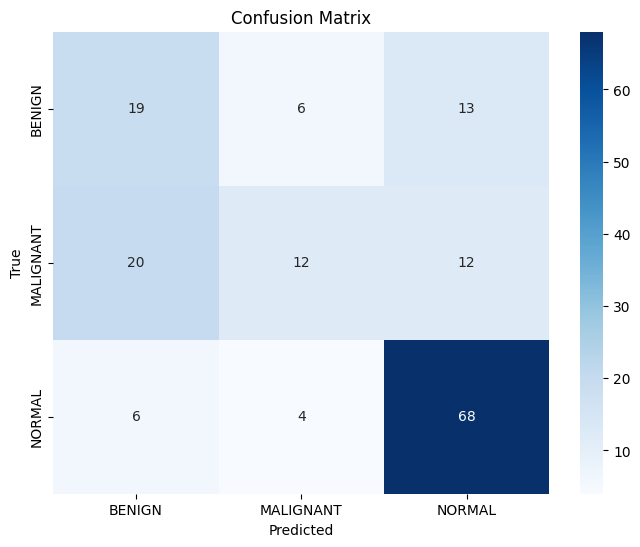

Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.42      0.50      0.46        38
   MALIGNANT       0.55      0.27      0.36        44
      NORMAL       0.73      0.87      0.80        78

    accuracy                           0.62       160
   macro avg       0.57      0.55      0.54       160
weighted avg       0.61      0.62      0.60       160



In [ ]:
# Kelas yang testing
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

12/12 [==============================] - 2s 105ms/step


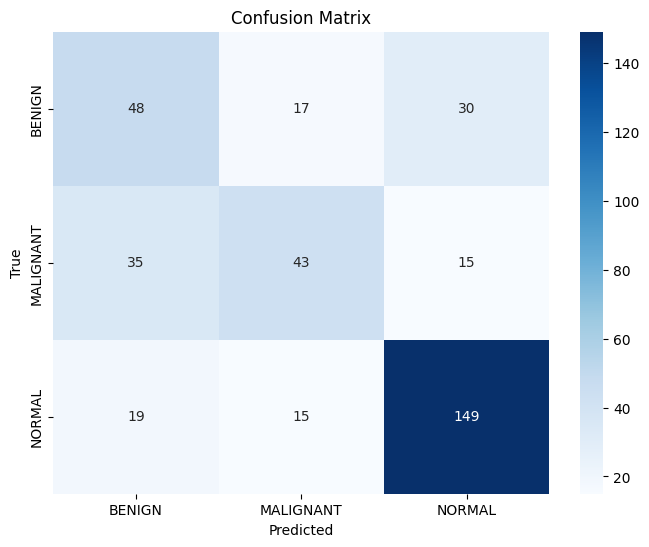

Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.47      0.51      0.49        95
   MALIGNANT       0.57      0.46      0.51        93
      NORMAL       0.77      0.81      0.79       183

    accuracy                           0.65       371
   macro avg       0.60      0.59      0.60       371
weighted avg       0.64      0.65      0.64       371



In [ ]:
# Kelas yang testing
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Evaluate the model
y_pred_probs_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_probs_train, axis=1)

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)